# Technical exercise - Bilberry

In [1]:
import gc
import glob
import os
import time
import warnings
from random import randrange


import cv2
import numpy as np
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Dropout
from keras.models import Sequential
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical  # convert to one-hot-encoding
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm_notebook

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = './data'
# /data is the folder where "fields" and "roads" are located

# Loading the data

In [4]:
def load_data(path, xdim=224, ydim=224):
    label_names = []
    X = []
    y = []
    count = 0
    directories = os.listdir(path)
    directories.sort()
    for dirname in tqdm_notebook(directories, desc="Loading images..."):
        if dirname == ".DS_Store": continue
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        files = glob.glob(data_path)
        files.sort()
        for f1 in files:
            img = cv2.imread(f1, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (int(xdim * 1), int(ydim * 1)))
            X.append(np.array(img))
            if dirname == "fields":
                y.append(1)
            elif dirname == "roads":
                y.append(0)
            count += 1
    X = np.array(X)
    y = np.array(y)
    print("\n ================= Summary of extraction ================= \n")
    print(count, ' images lues')
    print("\nX.shape = ", X.shape)
    print("y.shape = ", y.shape)
    print("Fields : y=1 \nRoads  : y=0")
    print("\n ================= End of summary ================= \n")
    gc.collect()
    return X, y, label_names

In [5]:
X, y, label_names = load_data(path_data)

Loading images...:   0%|          | 0/3 [00:00<?, ?it/s]


 ================= Summary of extraction ================= 

90  images lues

X.shape =  (90, 224, 224, 3)
y.shape =  (90,)
Fields : y=1 
Roads  : y=0

 ================= End of summary ================= 



In [6]:
X = X / 255.
# X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 3)
y = to_categorical(y)
print("\n")
print("--------------------------------------------------------------------------------\n")
print("\nX shape : {:19}   |   y shape : {}".format(str(X.shape), y.shape))
print("\n\n--------------------------------------------------------------------------------")
print("There is {} class and more than {} images collected from the datasets.".format(y.shape[1], y.shape[0]))
print("\n--------------------------------------------------------------------------------\n")
# print("y : \n", y)



--------------------------------------------------------------------------------


X shape : (90, 224, 224, 3)     |   y shape : (90, 2)


--------------------------------------------------------------------------------
There is 2 class and more than 90 images collected from the datasets.

--------------------------------------------------------------------------------



In [7]:
# function - onehot to labels
def oneHot_to_labels(onehot):
    for i in range(len(onehot)):
        if onehot[i] == 0:
            labeled = label_names[i]
    return labeled

num = randrange(y.shape[0])
print("\n\n--------------------------------------------------------------------------------")
print("n° {}\n".format(num))
print("One hot : {} ".format(y[num]))
print("\nLabeled : {} ".format(oneHot_to_labels(y[num])))



--------------------------------------------------------------------------------
n° 6

One hot : [0. 1.] 

Labeled : fields 




--------------------------------------------------------------------------------

                                   PLOT SOME IMAGES


--------------------------------------------------------------------------------


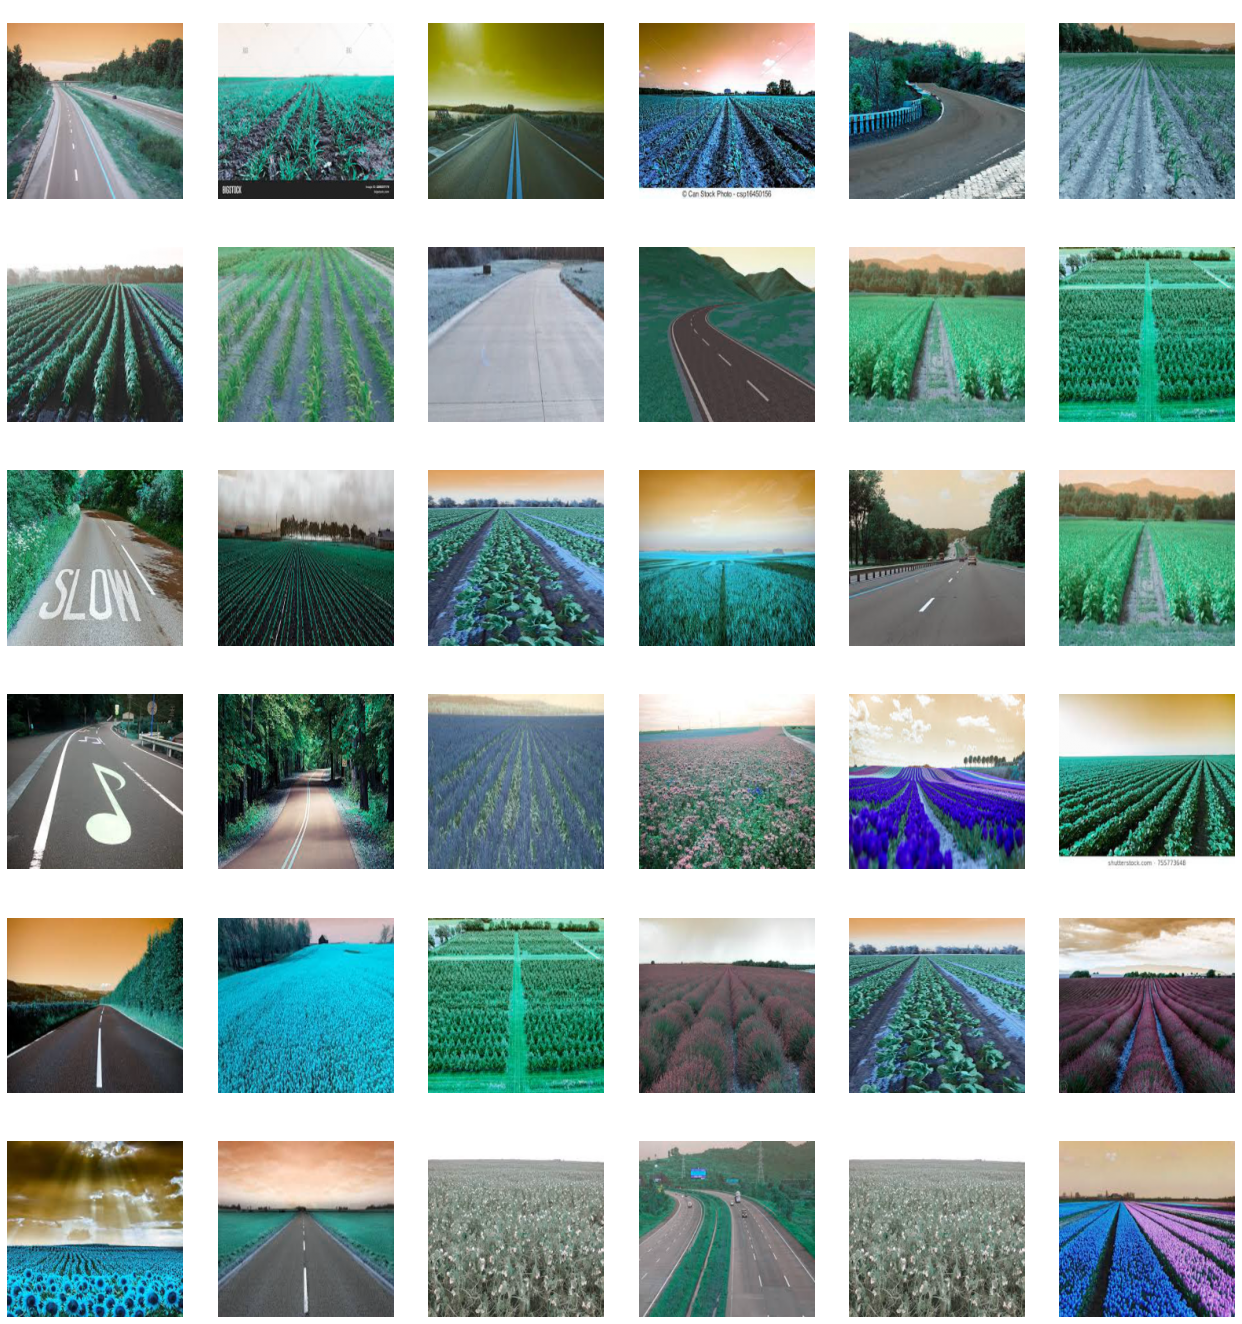

In [8]:
plt.figure(figsize=(22, 24))
print("\n")
print("--------------------------------------------------------------------------------\n")
print("                                   PLOT SOME IMAGES")
print("\n\n--------------------------------------------------------------------------------")

for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    r = randrange(y.shape[0])
    plt.imshow(X[r], cmap=plt.cm.colors.ListedColormap(['white', 'black']))
    # title_obj = plt.title("Class : {}".format(np.argmax(y[r])))
    title_obj = plt.title("Label : {}".format(oneHot_to_labels(y[r])))
    plt.setp(title_obj, color='white')
    plt.axis("off")

# Split the data into training 70%, validation 15%, and testing 15%

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("\nSplitting data ...\n")
print("\n=============================== Splitting data =============================== \n\n")
print("X_train shape   : {:19}    |    y_train shape : {}\n".format(str(X_train.shape), y_train.shape))
print("------------------------------------------------------------------------------")
print("X_val shape     : {:19}    |    y_val shape   : {}\n".format(str(X_val.shape), y_val.shape))
print("------------------------------------------------------------------------------")
print("X_test shape    : {:19}    |    y_test shape  : {}\n".format(str(X_test.shape), y_test.shape))


Splitting data ...


=============================== Splitting data =============================== 


X_train shape   : (63, 224, 224, 3)      |    y_train shape : (63, 2)

------------------------------------------------------------------------------
X_val shape     : (13, 224, 224, 3)      |    y_val shape   : (13, 2)

------------------------------------------------------------------------------
X_test shape    : (14, 224, 224, 3)      |    y_test shape  : (14, 2)



# Build the model

In [10]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Nadam(learning_rate=0.001) , metrics=['accuracy'])
    return model

In [11]:
model = create_model()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.7,
                                            min_lr=0.00000000001)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=1e-3,
                               patience=15,
                               verbose=0,
                               restore_best_weights=True)

model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)       

# model using transfer learning from ResNet 50

# Training the model ...

In [ ]:
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val),
                    callbacks=[learning_rate_reduction])
print("\n\n--- Training time : %s2f seconds ---" % (time.time() - start_time))

Epoch 1/50
2/2 [==============================] - 19s 10s/step - loss: 6.1727 - accuracy: 0.4444 - val_loss: 51.9365 - val_accuracy: 0.6154
Epoch 2/50
2/2 [==============================] - 20s 11s/step - loss: 64.4952 - accuracy: 0.5238 - val_loss: 2.0478 - val_accuracy: 0.3846
Epoch 3/50
2/2 [==============================] - 22s 11s/step - loss: 4.3812 - accuracy: 0.5556 - val_loss: 1.1298 - val_accuracy: 0.3846

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 4/50
2/2 [==============================] - 19s 10s/step - loss: 1.5756 - accuracy: 0.6349 - val_loss: 0.6677 - val_accuracy: 0.6923
Epoch 5/50
2/2 [==============================] - 22s 11s/step - loss: 0.3956 - accuracy: 0.8254 - val_loss: 0.5769 - val_accuracy: 0.6923
Epoch 6/50
2/2 [==============================] - 18s 9s/step - loss: 0.2965 - accuracy: 0.8413 - val_loss: 0.8710 - val_accuracy: 0.4615

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
Epo

# Evaluate the model on the test set

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("\n ================= Evaluation : model ================= \n")
print("  Results : \n")
print("Loss  : %.2f" % (score[0]))
print("Score : %.2f%%" % (score[1] * 100))

# Plot the loss and accuracy curves for training and validation

In [ ]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()


def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Loss')
    plt.legend()
    plt.show()


plot_scores(history)
plot_loss(history)

# Save the model

In [ ]:
!mkdir -p saved_models
# Saving the model for Future Inferences
model_json = model.to_json()
#.json is the architecture
with open("saved_models/bilberry_model.json", "w") as json_file:
    json_file.write(model_json)
#.h5 is the weights of the model
model.save('saved_models/bilberry_model.h5')

# Load the model - pretrained

In [ ]:
from keras.models import model_from_json

architecture_path = "saved_models/bilberry_model.json"
weight_path = "saved_models/bilberry_model.h5"

json_file = open(architecture_path, 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
model.load_weights(weight_path)
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
print("------------------------------ Model loaded ------------------------------")
print(model.summary())

# Predict the class of image

In [18]:
y_pred = model.predict(X_temp)

In [19]:
# function - one hot prediction -> label
def pred_to_label(onehot):
    new_onehot=[]
    for i in range(len(onehot)):
        if onehot[i] == max(onehot):
            new_onehot.append(1)
        else:
            new_onehot.append(0)
    #new_onehot va être égale à un hardmax onehot exemple : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
    labeled = oneHot_to_labels(new_onehot)
    return labeled

print("One hot (Prediction) : \n {} ".format(y_pred[7]))
print("\nLabeled : {} ".format(pred_to_label(y_pred[7])))

One hot (Prediction) : 
 [0.9349182  0.06508178] 

Labeled : roads 


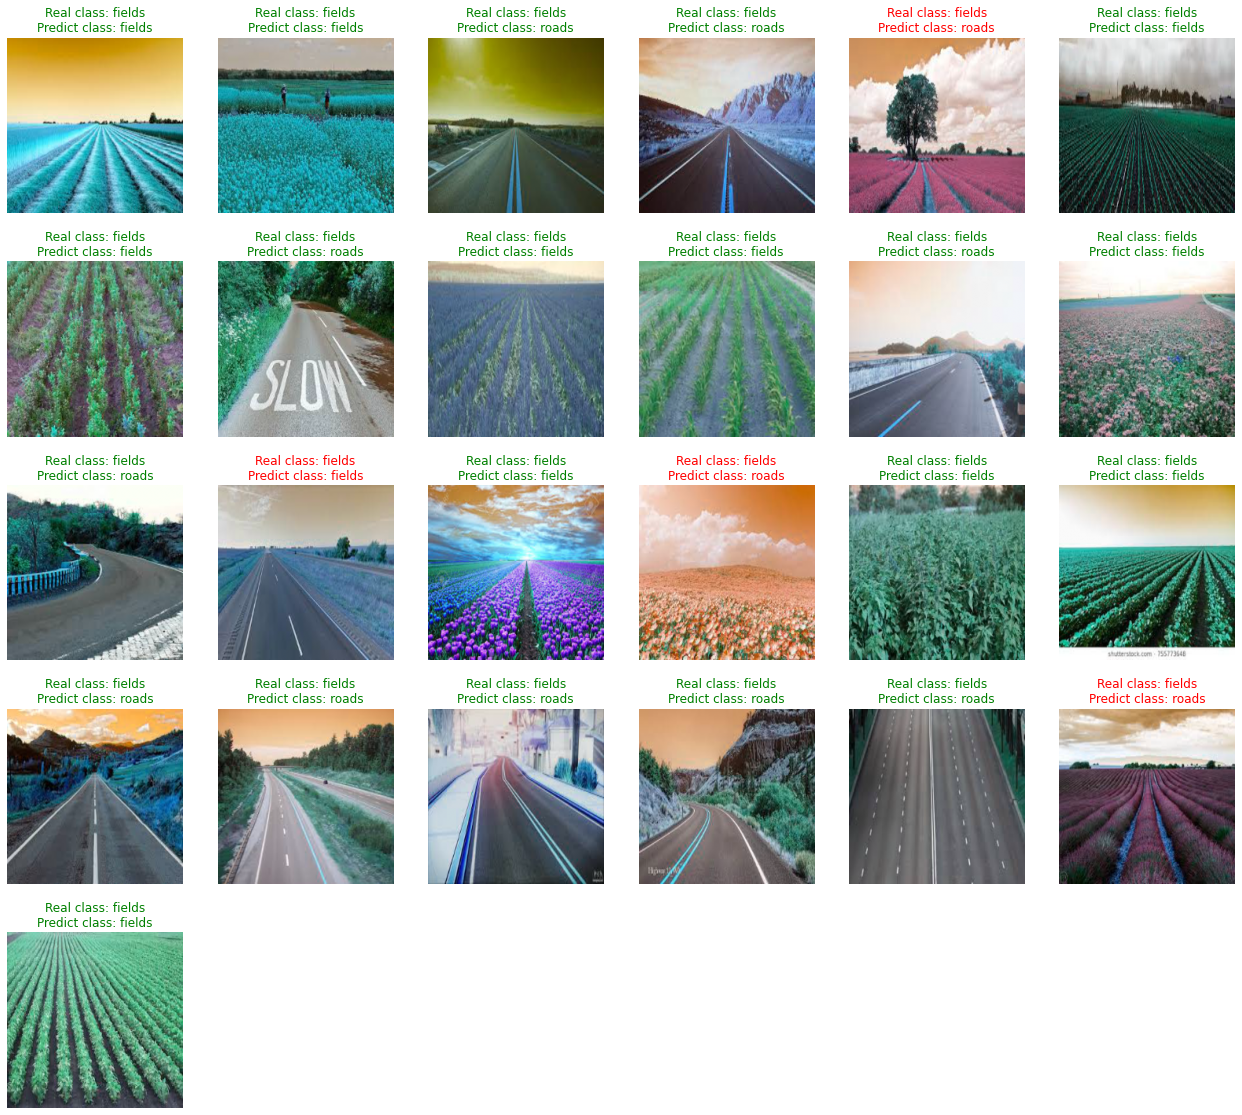

In [21]:
plt.figure(figsize=(22, 24))

for i in range(25):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(X_temp[i], cmap=plt.cm.binary)
    # title_obj = plt.title("Real class: {}\nPredict class: {}".format(np.argmax(y_temp[i]), y_pred[i].argmax()))
    title_obj = plt.title("Real label: {}\nPredict label: {}".format(oneHot_to_labels(y[i]), pred_to_label(y_pred[i])))
    if np.argmax(y_pred[i]) == np.argmax(y_temp[i]):
        plt.setp(title_obj, color='green')
    else:
        plt.setp(title_obj, color='red')
    plt.axis("off")